In [1]:
import argparse
parser = argparse.ArgumentParser()
# for training
parser.add_argument('--model_path', type=str, default='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/',help='path for saving trained models')
parser.add_argument('--model_dir', type=str, default='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/',help='path for saving trained models')
parser.add_argument('--num_steps', type=int, default=200)
parser.add_argument('--direction', type=int, default=0)

parser.add_argument('--seen_N', type=int, default=1)
parser.add_argument('--seen_NP', type=int, default=20)
parser.add_argument('--seen_s', type=int, default=0)
parser.add_argument('--seen_sp', type=int, default=1800)
parser.add_argument('--unseen_N', type=int, default=0)
parser.add_argument('--unseen_NP', type=int, default=0)
parser.add_argument('--unseen_s', type=int, default=0)
parser.add_argument('--unseen_sp', type=int, default=0)
parser.add_argument('--grad_step', type=int, default=1, help='number of gradient steps in continual learning')
# Model parameters
parser.add_argument('--total_input_size', type=int, default=8, help='dimension of total input')
parser.add_argument('--AE_input_size', nargs='+', type=int, default=32, help='dimension of input to AE')
parser.add_argument('--mlp_input_size', type=int , default=40, help='dimension of the input vector')
parser.add_argument('--output_size', type=int , default=4, help='dimension of the input vector')
parser.add_argument('--learning_rate', type=float, default=0.01)
parser.add_argument('--device', type=int, default=0, help='cuda device')
parser.add_argument('--data_folder', type=str, default='./data/cartpole_obs/')
parser.add_argument('--obs_file', type=str, default='./data/cartpole/obs.pkl')
parser.add_argument('--obc_file', type=str, default='./data/cartpole/obc.pkl')
parser.add_argument('--start_epoch', type=int, default=9950)
parser.add_argument('--env_type', type=str, default='cartpole_obs_4', help='s2d for simple 2d, c2d for complex 2d')
parser.add_argument('--world_size', nargs='+', type=float, default=[30.0, 40.0, 3.141592653589793, 2.0], help='boundary of world')
parser.add_argument('--opt', type=str, default='Adagrad')
parser.add_argument('--loss', type=str, default='mse')
parser.add_argument('--multigoal', type=int, default=0, help='using itermediate nodes as goal or not')

args = parser.parse_args('')
print(args)



Namespace(AE_input_size=32, data_folder='./data/cartpole_obs/', device=0, direction=0, env_type='cartpole_obs_4', grad_step=1, learning_rate=0.01, loss='mse', mlp_input_size=40, model_dir='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/', model_path='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/', multigoal=0, num_steps=200, obc_file='./data/cartpole/obc.pkl', obs_file='./data/cartpole/obs.pkl', opt='Adagrad', output_size=4, seen_N=1, seen_NP=20, seen_s=0, seen_sp=1800, start_epoch=9950, total_input_size=8, unseen_N=0, unseen_NP=0, unseen_s=0, unseen_sp=0, world_size=[30.0, 40.0, 3.141592653589793, 2.0])


In [2]:
'''
This is the main file to run gem_end2end network.
It simulates the real scenario of observing a data, puts it inside the memory (or not),
and trains the network using the data
after training at each step, it will output the R matrix described in the paper
https://arxiv.org/abs/1706.08840
and after sevral training steps, it needs to store the parameter in case emergency
happens
To make it work in a real-world scenario, it needs to listen to the observer at anytime,
and call the network to train if a new data is available
(this thus needs to use multi-process)
here for simplicity, we just use single-process to simulate this scenario
'''
from __future__ import print_function
import sys
sys.path.append('deps/sparse_rrt')

#from model.mlp import MLP
import numpy as np
import argparse
import os
import copy
import os
import gc
import random
#from sparse_rrt.systems import standard_cpp_systems
#from sparse_rrt import _sst_module
from tools import data_loader
import jax
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt


import math
import time
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module

import matplotlib.pyplot as plt
#fig = plt.figure()

import sys
sys.path.append('..')

import numpy as np
#from tvlqr.python_tvlqr import tvlqr
#from tvlqr.python_lyapunov import sample_tv_verify
from plan_utility.data_structure import *
from plan_utility.line_line_cc import line_line_cc
import torch
import model.AE.identity as cae_identity
from model.mlp import MLP
from model import mlp_acrobot, mlp_cartpole
from model.AE import CAE_acrobot_voxel_2d, CAE_acrobot_voxel_2d_2, CAE_acrobot_voxel_2d_3, CAE_cartpole_voxel_2d
from model.mpnet import KMPNet
from tools import data_loader
from tools.utility import *
from plan_utility import cart_pole, cart_pole_obs, pendulum, acrobot_obs
import argparse
import numpy as np
import random
import os
from sparse_rrt import _sst_module



def IsInCollision(x, obc, obc_width=4.):
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5

    STATE_X = 0
    STATE_V = 1
    STATE_THETA = 2
    STATE_W = 3
    CONTROL_A = 0

    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2

    
    if x[0] < MIN_X or x[0] > MAX_X:
        return True
    
    H = 0.5
    pole_x1 = x[0]
    pole_y1 = H
    pole_x2 = x[0] + L * np.sin(x[2])
    pole_y2 = H + L * np.cos(x[2])

    
    for i in range(len(obc)):
        for j in range(0, 8, 2):
            x1 = obc[i][j]
            y1 = obc[i][j+1]
            x2 = obc[i][(j+2) % 8]
            y2 = obc[i][(j+3) % 8]
            if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                return True
    return False

def enforce_bounds(state):
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5

    STATE_X = 0
    STATE_V = 1
    STATE_THETA = 2
    STATE_W = 3
    CONTROL_A = 0

    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    if state[1]<MIN_V:
        state[1]=MIN_V
    elif state[1]>MAX_V:
        state[1]=MAX_V

    if state[2]<-np.pi:
        state[2]+=2*np.pi
    elif state[2]>np.pi:
        state[2]-=2*np.pi

    if state[3]<MIN_W:
        state[3]=MIN_W
    elif state[3]>MAX_W:
        state[3]=MAX_W
    return state







loading...
loading...


/home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/plan_utility/line_line_cc.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
/home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/plan_utility/line_line_cc.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
21


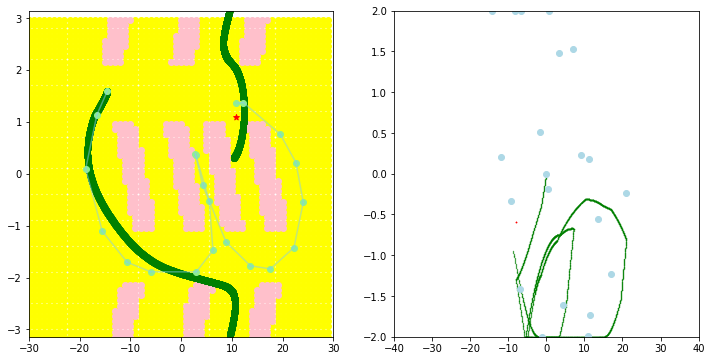

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
20


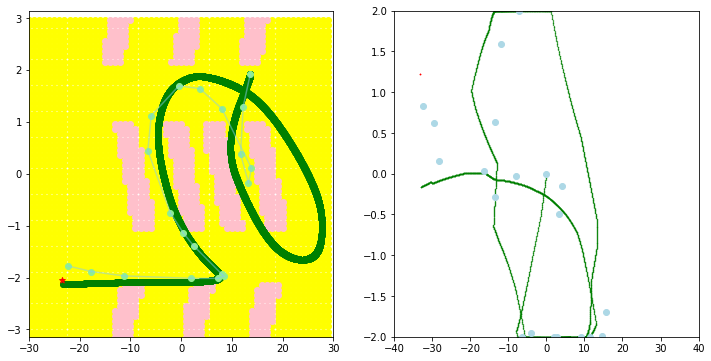

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
8


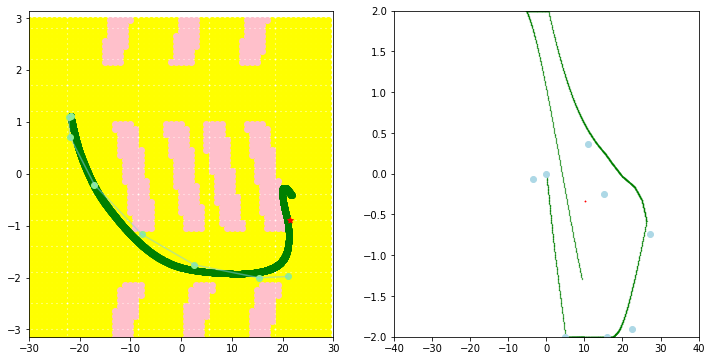

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
23


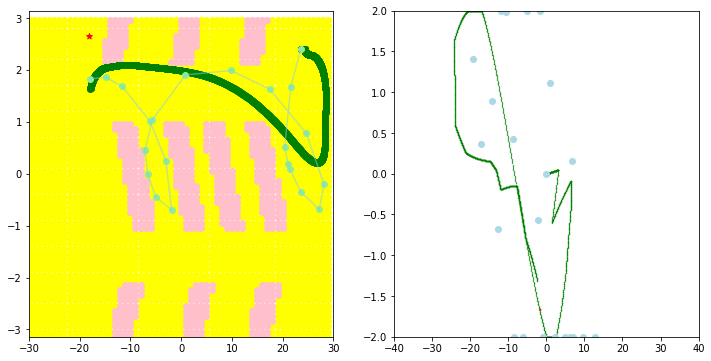

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
14


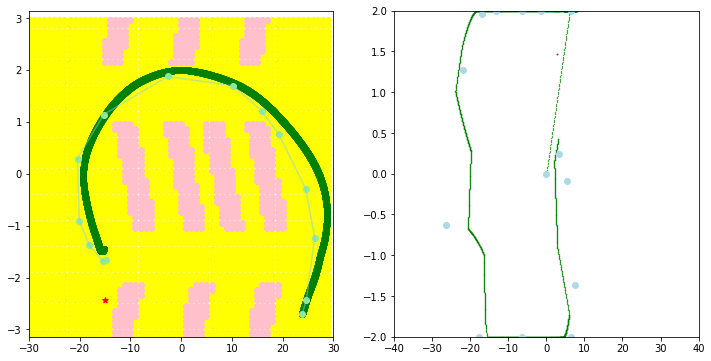

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
14


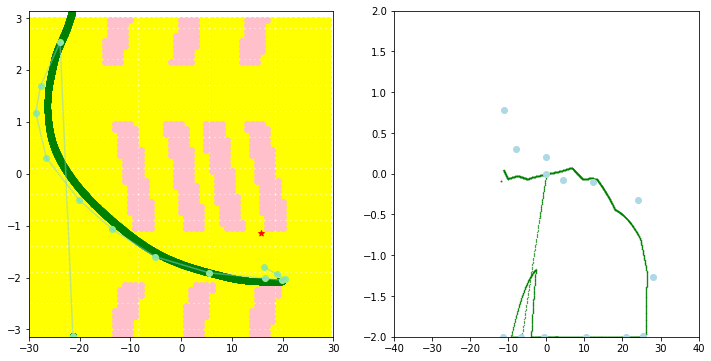

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
14


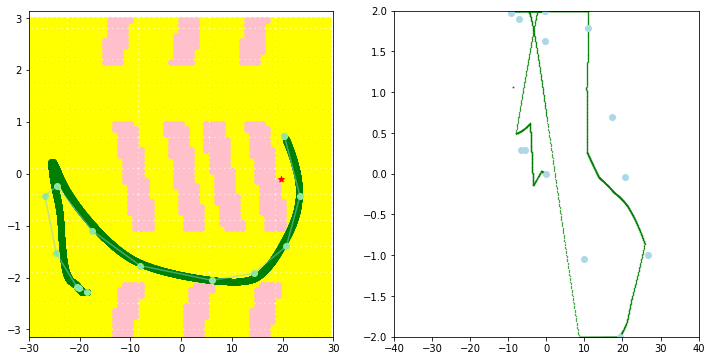

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
30


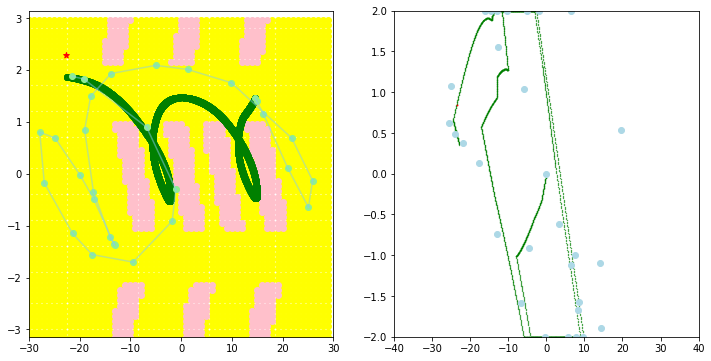

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
11


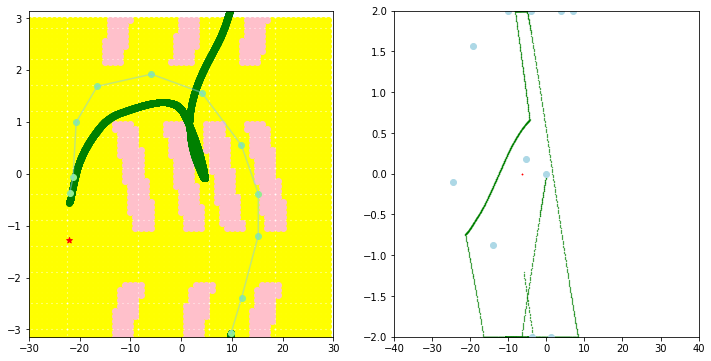

feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-15.           0.           2.15840735   0.        ]
 [-15.           0.           2.25840735   0.        ]
 [-15.           0.           2.35840735   0.        ]
 ...
 [ 20.           0.          -0.74159265   0.        ]
 [ 20.           0.          -0.64159265   0.        ]
 [ 20.           0.          -0.54159265   0.        ]]
24


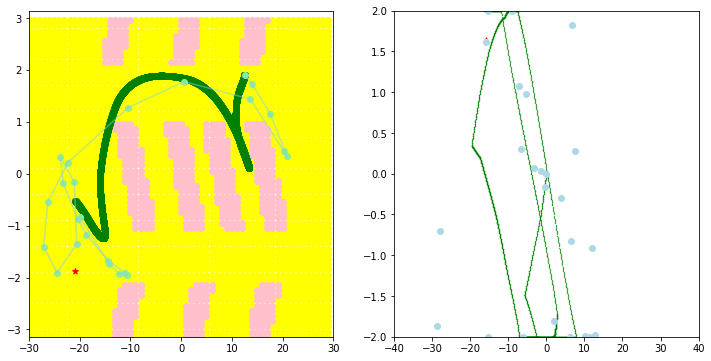

IndexError: index 1 is out of bounds for axis 0 with size 1

In [3]:


# set seed
torch_seed = np.random.randint(low=0, high=1000)
np_seed = np.random.randint(low=0, high=1000)
py_seed = np.random.randint(low=0, high=1000)
np.random.seed(np_seed)
random.seed(py_seed)
# Build the models

# setup evaluation function and load function
if args.env_type == 'pendulum':
    obs_file = None
    obc_file = None
    obs_f = False
    #system = standard_cpp_systems.PSOPTPendulum()
    #bvp_solver = _sst_module.PSOPTBVPWrapper(system, 2, 1, 0)
elif args.env_type == 'cartpole_obs':
    obs_file = None
    obc_file = None
    obs_f = True
    obs_width = 4.0
    step_sz = 0.002
    psopt_system = _sst_module.PSOPTCartPole()
    cpp_propagator = _sst_module.SystemPropagator()

    #system = standard_cpp_systems.RectangleObs(obs, 4., 'cartpole')
    dynamics = lambda x, u, t: cpp_propagator.propagate(psopt_system, x, u, t)

    normalize = cart_pole_obs.normalize
    unnormalize = cart_pole_obs.unnormalize
    system = _sst_module.PSOPTCartPole()
    mlp = mlp_cartpole.MLP
    cae = CAE_cartpole_voxel_2d
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = cart_pole_obs.enforce_bounds
    step_sz = 0.002
    num_steps = 100
elif args.env_type == 'cartpole_obs_2':
    obs_file = None
    obc_file = None
    obs_f = True
    obs_width = 4.0
    step_sz = 0.002
    psopt_system = _sst_module.PSOPTCartPole()
    cpp_propagator = _sst_module.SystemPropagator()

    #system = standard_cpp_systems.RectangleObs(obs, 4., 'cartpole')
    dynamics = lambda x, u, t: cpp_propagator.propagate(psopt_system, x, u, t)

    normalize = cart_pole_obs.normalize
    unnormalize = cart_pole_obs.unnormalize
    system = _sst_module.PSOPTCartPole()
    mlp = mlp_cartpole.MLP2
    cae = CAE_cartpole_voxel_2d
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = cart_pole_obs.enforce_bounds
    step_sz = 0.002
    num_steps = 100
elif args.env_type == 'cartpole_obs_3':
    obs_file = None
    obc_file = None
    obs_f = True
    obs_width = 4.0
    step_sz = 0.002
    psopt_system = _sst_module.PSOPTCartPole()
    cpp_propagator = _sst_module.SystemPropagator()

    #system = standard_cpp_systems.RectangleObs(obs, 4., 'cartpole')
    dynamics = lambda x, u, t: cpp_propagator.propagate(psopt_system, x, u, t)

    normalize = cart_pole_obs.normalize
    unnormalize = cart_pole_obs.unnormalize
    system = _sst_module.PSOPTCartPole()
    mlp = mlp_cartpole.MLP4
    cae = CAE_cartpole_voxel_2d
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = cart_pole_obs.enforce_bounds
    step_sz = 0.002
    num_steps = 200
elif args.env_type == 'cartpole_obs_4':
    obs_file = None
    obc_file = None
    obs_f = True
    obs_width = 4.0
    step_sz = 0.002
    psopt_system = _sst_module.PSOPTCartPole()
    cpp_propagator = _sst_module.SystemPropagator()

    #system = standard_cpp_systems.RectangleObs(obs, 4., 'cartpole')
    dynamics = lambda x, u, t: cpp_propagator.propagate(psopt_system, x, u, t)

    normalize = cart_pole_obs.normalize
    unnormalize = cart_pole_obs.unnormalize
    system = _sst_module.PSOPTCartPole()
    mlp = mlp_cartpole.MLP3
    cae = CAE_cartpole_voxel_2d
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = cart_pole_obs.enforce_bounds
    step_sz = 0.002
    num_steps = 200


elif args.env_type == 'acrobot_obs':
    obs_file = None
    obc_file = None

    obs_f = True
    obs_width = 6.0

    #system = standard_cpp_systems.RectangleObs(obs_list, args.obs_width, 'acrobot')
    #bvp_solver = _sst_module.PSOPTBVPWrapper(system, 4, 1, 0)




# load data
print('loading...')

# load data
print('loading...')
if args.seen_N > 0:
    seen_test_data = data_loader.load_test_dataset(args.seen_N, args.seen_NP,
                              args.data_folder, obs_f, args.seen_s, args.seen_sp)
if args.unseen_N > 0:
    unseen_test_data = data_loader.load_test_dataset(args.unseen_N, args.unseen_NP,
                              args.data_folder, obs_f, args.unseen_s, args.unseen_sp)
obc, obs, paths, sgs, path_lengths, controls, costs = seen_test_data

#plt.ion()
#hl_real, = ax.plot([], [], 'r')
def update_line(h, ax, new_data):
    h.set_data(np.append(h.get_xdata(), new_data[0]), np.append(h.get_ydata(), new_data[1]))
    #h.set_xdata(np.append(h.get_xdata(), new_data[0]))
    #h.set_ydata(np.append(h.get_ydata(), new_data[1]))


def draw_update_line(ax):
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()


for envi in range(2):
    for pathi in range(10):

        obs_i = obs[envi]
        new_obs_i = []
        obs_i = obs[envi]
        plan_res_path = []
        plan_time_path = []
        plan_cost_path = []
        data_cost_path = []
        for k in range(len(obs_i)):
            obs_pt = []
            obs_pt.append(obs_i[k][0]-obs_width/2)
            obs_pt.append(obs_i[k][1]-obs_width/2)
            obs_pt.append(obs_i[k][0]-obs_width/2)
            obs_pt.append(obs_i[k][1]+obs_width/2)
            obs_pt.append(obs_i[k][0]+obs_width/2)
            obs_pt.append(obs_i[k][1]+obs_width/2)
            obs_pt.append(obs_i[k][0]+obs_width/2)
            obs_pt.append(obs_i[k][1]-obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i

        # visualization
        plt.ion()
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121)
        ax_vel = fig.add_subplot(122)
        #ax.set_autoscale_on(True)
        ax.set_xlim(-30, 30)
        ax.set_ylim(-np.pi, np.pi)
        ax_vel.set_xlim(-40, 40)
        ax_vel.set_ylim(-2, 2)

        hl, = ax.plot([], [], 'b')
        #hl_real, = ax.plot([], [], 'r')
        hl_for, = ax.plot([], [], 'g')
        hl_back, = ax.plot([], [], 'r')
        hl_for_mpnet, = ax.plot([], [], 'lightgreen')
        hl_back_mpnet, = ax.plot([], [], 'salmon')

        #print(obs)
        def update_line(h, ax, new_data):
            new_data = wrap_angle(new_data, propagate_system)
            h.set_data(np.append(h.get_xdata(), new_data[0]), np.append(h.get_ydata(), new_data[1]))
            #h.set_xdata(np.append(h.get_xdata(), new_data[0]))
            #h.set_ydata(np.append(h.get_ydata(), new_data[1]))

        def remove_last_k(h, ax, k):
            h.set_data(h.get_xdata()[:-k], h.get_ydata()[:-k])

        def draw_update_line(ax):
            #ax.relim()
            #ax.autoscale_view()
            fig.canvas.draw()
            fig.canvas.flush_events()
            #plt.show()

        def wrap_angle(x, system):
            circular = system.is_circular_topology()
            res = np.array(x)
            for i in range(len(x)):
                if circular[i]:
                    # use our previously saved version
                    res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
                    if res[i] > np.pi:
                        res[i] = res[i] - 2*np.pi
            return res
        dx = 1
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*30./dx)
        jmin = 0
        jmax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(jmin, jmax):
                x = np.array([dx*i-30, 0., dtheta*j-np.pi, 0.])
                if IsInCollision(x, obs_i):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)
        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        ax.scatter(feasible_points[:,0], feasible_points[:,2], c='yellow')
        ax.scatter(infeasible_points[:,0], infeasible_points[:,2], c='pink')
        #for i in range(len(data)):
        #    update_line(hl, ax, data[i])
        draw_update_line(ax)
        #state_t = start_state

        xs = paths[envi][pathi]
        us = controls[envi][pathi]
        ts = costs[envi][pathi]
        sg = sgs[envi][pathi]
        # propagate data
        p_start = xs[0]
        detail_paths = [p_start]
        detail_controls = []
        detail_costs = []
        state = [p_start]
        control = []
        cost = []
        for k in range(len(us)):
            #state_i.append(len(detail_paths)-1)
            max_steps = int(ts[k]/step_sz)
            accum_cost = 0.
            #print('p_start:')
            #print(p_start)
            #print('data:')
            #print(paths[i][j][k])
            # modify it because of small difference between data and actual propagation
            p_start = xs[k]
            state[-1] = xs[k]
            for step in range(1,max_steps+1):
                p_start = dynamics(p_start, us[k], step_sz)
                p_start = enforce_bounds(p_start)
                detail_paths.append(p_start)
                accum_cost += step_sz
                if (step % 1 == 0) or (step == max_steps):
                    state.append(p_start)
                    #print('control')
                    #print(controls[i][j])
                    cost.append(accum_cost)
                    accum_cost = 0.
        #print('p_start:')
        #print(p_start)
        #print('data:')
        #print(paths[i][j][-1])
        state[-1] = xs[-1]
        #print(len(state))


        xs_to_plot = np.array(state)
        for i in range(len(xs_to_plot)):
            xs_to_plot[i] = wrap_angle(xs_to_plot[i], psopt_system)
        ax.scatter(xs_to_plot[:,0], xs_to_plot[:,2], c='green')
        # draw start and goal
        #ax.scatter(start_state[0], goal_state[0], marker='X')
        draw_update_line(ax)
        ax_vel.scatter(xs_to_plot[:,1], xs_to_plot[:,3], c='green', s=0.1)
        #draw_update_line(ax_vel)

        #plt.waitforbuttonpress()
        ax.scatter(sg[0][0], sg[0][2], c='blue', marker='*')
        ax.scatter(sg[1][0], sg[1][2], c='red', marker='*')

        ax_vel.scatter(sg[0][1], sg[0][3], c='blue', s=1., marker='*')
        ax_vel.scatter(sg[1][1], sg[1][3], c='red', s=1., marker='*')


        
        # load mpc result
        result_path = '../mpc-mpnet-cuda-yinglong/results/cpp_full/cartpole_obs/default_small_model_batch/paths/'
        result_path += 'path_%d_%d.npy' % (envi+args.seen_s, pathi+args.seen_sp)
        res_solution = np.load(result_path, allow_pickle=True)
        # find path



        # visualize mpc path
        
        xs = res_solution[0]
        xs_to_plot = xs
        print(len(xs_to_plot))
        for i in range(len(xs_to_plot)):
            xs_to_plot[i] = wrap_angle(xs_to_plot[i], psopt_system)
        ax.scatter(xs_to_plot[:,0], xs_to_plot[:,2], c='lightgreen')
        
        for i in range(len(xs_to_plot)-1):
            ax.plot([xs_to_plot[i,0], xs_to_plot[i+1,0]], [xs_to_plot[i,2], xs_to_plot[i+1,2]], c='skyblue', alpha=0.5)

        # draw start and goal
        #ax.scatter(start_state[0], goal_state[0], marker='X')
        draw_update_line(ax)
        ax_vel.scatter(xs_to_plot[:,1], xs_to_plot[:,3], c='lightblue')
        draw_update_line(ax_vel)
        plt.show()
